In [8]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle as pk
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, peak_prominences

from SHAPVisualizer import plot_shap_spread

# Compute SHAP from CNN 

Apply eXplainable AI (XAI) method SHAP to brown dwarf convolutional neural network to get feature importance.

## **1. Load and Preprocess Training Data**

In [9]:
# Load or create reference data path
__dataset_path__ = os.getenv("TelescopeML_reference_data")
__folder__ = "training_datasets"

# DataFrame with cols grid points then spectra
__dataset_file__ = "browndwarf_R100_v4_newWL_v3.csv.bz2"
dataset = pd.read_csv(os.path.join(__dataset_path__,__folder__,__dataset_file__), compression='bz2')

# Wavelength grid of model
__wavelength_file__ = "wl.csv"
wl = pd.read_csv(os.path.join(__dataset_path__,__folder__,__wavelength_file__)).to_numpy().squeeze()

### 1.1 Input and Output

In [10]:
# Model parameters
parameters = np.array(['gravity',
             'temperature',
             'c_o_ratio',
             'metallicity'])

# Training variables
X = dataset.drop(
    columns=parameters)

# Target/Output feature variables
y = dataset[parameters]

# log transform temperature variable
y.loc[:, 'temperature'] = np.log10(y['temperature'])

### 1.2 Standardize

In [11]:
# Standardize input
scaler_X = StandardScaler()
X_standardized_rowwise = scaler_X.fit_transform(X.T).T
X_standardized_rowwise=X_standardized_rowwise.reshape(-1, 104, 1) # add extra dim for CNN

# Standardize output
scaler_y = StandardScaler()
y_standardized_columnwise = scaler_y.fit_transform(y)

# Metadata
X_min,X_max = X.min(axis=1),X.max(axis=1)
df_MinMax = pd.DataFrame((X_min, X_max)).T
df_MinMax.rename(columns={0:'min', 1:'max'}, inplace=True)
X_meta = df_MinMax.to_numpy()

# Standardize metadata
scaler_X = StandardScaler()
X_standardized_columnwise = scaler_X.fit_transform(X_meta)

### 1.3 Sample background and test data

In [12]:
n_background = 1000
n_test = 300

# Choose random background IDs
np.random.seed(0) # for reproducability
idxs = np.random.choice(X_standardized_rowwise.shape[0], size=n_background, replace=False)
# Background data
background_spectrum = X_standardized_rowwise[idxs]  
background_meta = X_standardized_columnwise[idxs]

# Choose random test IDs (no overlap with background)
all_idxs = np.arange(X_standardized_rowwise.shape[0])
remaining_idxs = np.setdiff1d(all_idxs, idxs)
# Test data
test_idxs = np.random.choice(remaining_idxs, size=n_test, replace=False)
test_spectrum = X_standardized_rowwise[test_idxs]
test_meta = X_standardized_columnwise[test_idxs]

## **2. Load and Wrap CNN to Single-Output**

In [13]:
__folder__ = "trained_models"
__model_file__ = "sonora_bobcat_CNN.keras"

loaded_model = load_model(os.path.join(__folder__,__model_file__), compile=False)
loaded_model.compile(loss='huber_loss',optimizer=Adam(learning_rate=0.00018890368162236508),metrics=['mae'])

### **Needs to be generalized⬇️**
Take parameter list and wrap CNN automatically and compute shap values and save/show results and plots. Or can be kept as a manual notebook process

In [15]:
# Wrap the model to single output: temperature
temperature_model = Model(inputs=loaded_model.inputs,
                      outputs=loaded_model.get_layer('output__temperature').output)

# Wrap the model to single output: C/O ratio
CO_model = Model(inputs=loaded_model.inputs,
                      outputs=loaded_model.get_layer('output__c_o_ratio').output)

# Wrap the model to single output: M/H
metallicity_model = Model(inputs=loaded_model.inputs,
                      outputs=loaded_model.get_layer('output__metallicity').output)

# Wrap the model to single output: gravity
gravity_model = Model(inputs=loaded_model.inputs,
                      outputs=loaded_model.get_layer('output__gravity').output)


## **3. Compute SHAP**

### 3.1 Temperature

In [16]:
# Instantiate SHAP
temp_explainer = shap.DeepExplainer(temperature_model, [background_spectrum, background_meta])
# Compute SHAP values (takes 5+ min)
shap_values_temp = temp_explainer.shap_values([test_spectrum, test_meta])

/Users/emader/opt/anaconda3/envs/TelescopeML/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/emader/opt/anaconda3/envs/TelescopeML/lib/python3.9/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [18]:
# Remove last dimension for spectrum
spectrum_shap_temp = np.squeeze(shap_values_temp[0])
# Mean over tests cases and absolute value
mean_abs_shap_temp = np.mean(np.abs(spectrum_shap_temp), axis=0) 
      
# Save as NPY
np.save("shap_values/spectrum_shap_temperature.npy",spectrum_shap_temp)

### 3.2 C/O Ratio

In [ ]:
# Instantiate SHAP
CO_explainer = shap.DeepExplainer(CO_model, [background_spectrum, background_meta])
# Compute SHAP values (takes 5+ min)
shap_values_CO = CO_explainer.shap_values([test_spectrum, test_meta])

In [ ]:
# Remove last dimension for spectrum
spectrum_shap_CO = np.squeeze(shap_values_CO[0])
# Mean over tests cases and absolute value
mean_abs_shap_CO = np.mean(np.abs(spectrum_shap_CO), axis=0) 

# Save as NPY
np.save("shap_values/spectrum_shap_c_o_ratio.npy",spectrum_shap_CO)

### 3.3 Metallicity

In [ ]:
# Instantiate SHAP
met_explainer = shap.DeepExplainer(metallicity_model, [background_spectrum, background_meta])
# Compute SHAP values (takes 5+ min)
shap_values_met = met_explainer.shap_values([test_spectrum, test_meta])

In [ ]:
# Remove last dimension for spectrum
spectrum_shap_met = np.squeeze(shap_values_met[0])
# Mean over tests cases and absolute value
mean_abs_shap_met = np.mean(np.abs(spectrum_shap_met), axis=0) 

# Save as NPY
np.save("shap_values/spectrum_shap_metallicity.npy",spectrum_shap_met)

### 3.4 Gravity

In [11]:
# Instantiate SHAP
grav_explainer = shap.DeepExplainer(gravity_model, [background_spectrum, background_meta])
# Compute SHAP values (takes 5+ min)
shap_values_grav = grav_explainer.shap_values([test_spectrum, test_meta])

In [ ]:
# Remove last dimension for spectrum
spectrum_shap_grav = np.squeeze(shap_values_grav[0])
# Mean over tests cases and absolute value
mean_abs_shap_grav = np.mean(np.abs(spectrum_shap_grav), axis=0) 

# Save as NPY
np.save("shap_values/spectrum_shap_gravity.npy",spectrum_shap_grav)

## **4. Analyze Output**

### 4.1 SHAP Feature Importance for all Parameters

In [20]:
# Load previously ran SHAP
__load__ = True

In [23]:
if __load__:
    abs_shap_dict = {}
    for p in parameters:
        spectrum_shap_p = np.load(f"shap_values/spectrum_shap_{p}.npy",allow_pickle=True)
        abs_shap_dict[p] = np.mean(np.abs(spectrum_shap_p), axis=0)

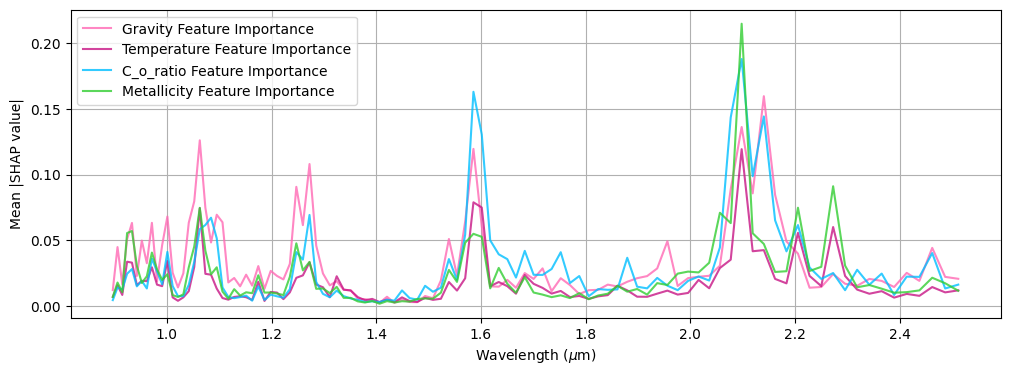

In [77]:
# Visualize
plt.figure(figsize=(12, 4))
colors = ['#FF69B4',  # hot pink
          '#C71585',  # medium violet-red
          '#00BFFF',  # deep sky blue
          '#32CD32']  # lime green
for i,p in enumerate(parameters):
    plt.plot(wl, abs_shap_dict[p],label=f'{p.capitalize()} Feature Importance',
             color=colors[i], alpha=0.8)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Mean |SHAP value|')
plt.legend()
plt.grid(True)

### 4.2 SHAP Versus Spectra: Temperature

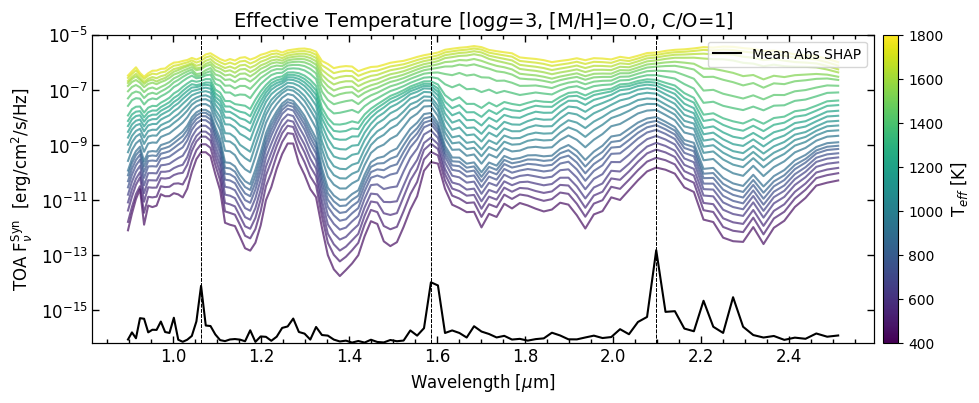

In [68]:
p = 'temperature'
arr = abs_shap_dict[p]
norm_mean_shap = (arr - arr.min()) / (arr.max() - arr.min())


filter_bounds = {'gravity': (3,3),
                 'c_o_ratio' : (1,1),
                 'metallicity' : (0.0,0.0),
                 'temperature': (400, 1800)}

plot_shap_spread(train_BD, 
                 wl, 
                 feature_to_plot=p, 
                 filter_bounds=filter_bounds, 
                 norm_mean_shap=norm_mean_shap,
                )

### 4.3 SHAP Versus Spectra: Gravity

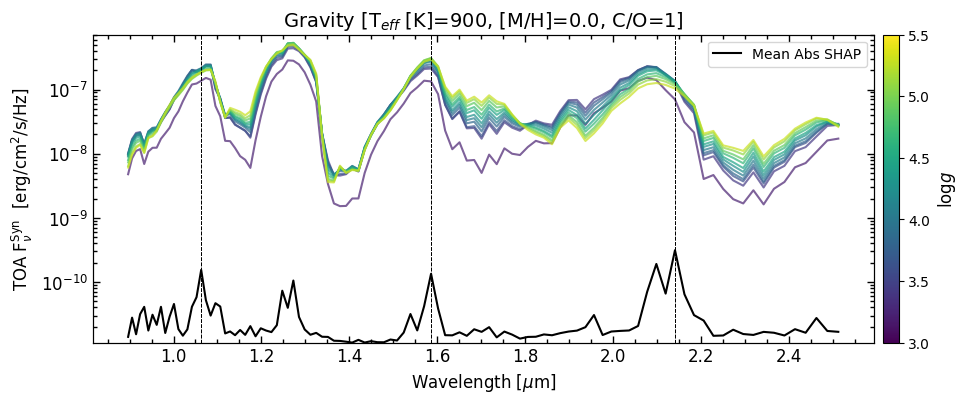

In [69]:
p = 'gravity'
arr = abs_shap_dict[p]
norm_mean_shap = (arr - arr.min()) / (arr.max() - arr.min())

filter_bounds = {'gravity': (3,5.5),
                 'c_o_ratio' : (1,1),
                 'metallicity' : (0.0,0.0),
                 'temperature': (900, 900)}

plot_shap_spread(train_BD, 
                 wl, 
                 feature_to_plot=p, 
                 filter_bounds=filter_bounds, 
                 norm_mean_shap=norm_mean_shap,
                )

### 4.4 SHAP Versus Spectra: C/O Ratio

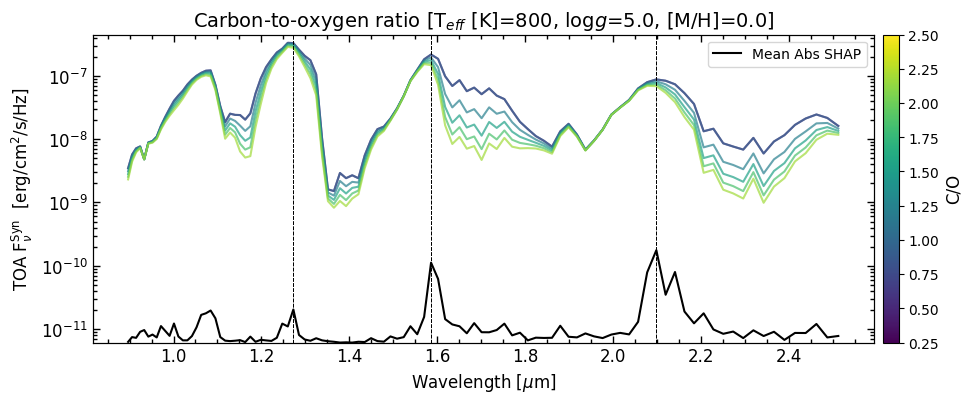

In [70]:
p = 'c_o_ratio'
arr = abs_shap_dict[p]
norm_mean_shap = (arr - arr.min()) / (arr.max() - arr.min())


filter_bounds = {'gravity': (5.,5),
                 'c_o_ratio' : (0.25,2.5),
                 'metallicity' : (0.0,0.0),
                 'temperature': (800, 800)}



plot_shap_spread(train_BD, 
                 wl, 
                 feature_to_plot=p, 
                 filter_bounds=filter_bounds, 
                 norm_mean_shap=norm_mean_shap,
                )